# WGAN Training

## imports

In [44]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from models.WGAN import WGAN
from utils.loaders import load_safari, load_cifar



In [45]:
RUN_ID = '0039'
RUN_FOLDER = os.path.join("./run", RUN_ID)

IMAGE_SIZE = 32

## data

In [52]:
label = 0
(x_train, y_train) = load_cifar(label, 10)
# (x_train, y_train) = load_safari('elephant')




## architecture

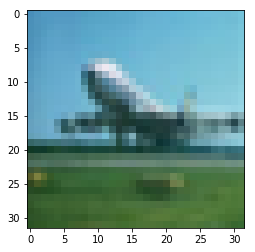

In [53]:
plt.imshow((x_train[100,:,:,:]+1)/2)

In [54]:
print(np.min(x_train))
print(np.max(x_train))

-1.0
1.0


In [55]:
x_train.shape

(6000, 32, 32, 3)

In [57]:
#works

gan = WGAN(input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
        , critic_conv_filters = [32,64,128,256]
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,1]
        , critic_conv_padding = 'same'
        , critic_batch_norm_momentum = 0.8
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.00005
        , generator_initial_dense_layer_size = (4,4,256)
        , generator_upsample = [1,1,1,1]
        , generator_conv_filters = [128,64,32,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2,2,1]
        , generator_conv_padding = 'same'
        , generator_batch_norm_momentum = 0.8
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.00005
        , optimiser = 'rmsprop'
        , z_dim = 100
        )





# gan = WGAN(input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
#         , critic_conv_filters = [32,64,128,128]
#         , critic_conv_kernel_size = [5,5,5,5]
#         , critic_conv_strides = [2,2,2,1]
#         , critic_conv_padding = 'same'
#         , critic_batch_norm_momentum = None
#         , critic_activation = 'leaky_relu'
#         , critic_dropout_rate = None
#         , critic_learning_rate = 0.00005
#         , generator_initial_dense_layer_size = (4, 4, 128)
#         , generator_upsample = [2,2, 2,1]
#         , generator_conv_filters = [128,64,32,3]
#         , generator_conv_kernel_size = [5,5,5,5]
#         , generator_conv_strides = [1,1, 1,1]
#         , generator_conv_padding = 'same'
#         , generator_batch_norm_momentum = 0.8
#         , generator_activation = 'leaky_relu'
#         , generator_dropout_rate = None
#         , generator_learning_rate = 0.00005
#         , optimiser = 'rmsprop'
#         , z_dim = 100
#         )

gan.save(RUN_FOLDER)


In [58]:
#gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [59]:
gan.critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 8, 8, 64)          51264     
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
critic_conv_2 (Conv2D)       (None, 4, 4, 128)         204928    
__________

In [60]:
gan.generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              413696    
_________________________________________________________________
batch_normalization_17 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
generator_conv_0 (Conv2DTran (None, 8, 8, 128)         819328    
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 8, 128)         512       
__________

## training

In [85]:
gan.train(     
    x_train
    , batch_size = 128
    , epochs = 100000
    , run_folder = RUN_FOLDER
    , print_every_n_batches = 5
    , n_critic = 5
    , large_it_critic = 5
    , large_n_critic = 5
    , clip_threshold = 0.01
    , using_generator = False
)

3728 (5, 1) [D loss: (-0.009)(R -0.014, F -0.003)]  [G loss: 0.011] 
3729 (5, 1) [D loss: (-0.003)(R -0.003, F -0.004)]  [G loss: 0.014] 
3730 (5, 1) [D loss: (-0.006)(R -0.002, F -0.010)]  [G loss: 0.021] 
3731 (5, 1) [D loss: (-0.005)(R -0.001, F -0.010)]  [G loss: 0.015] 
3732 (5, 1) [D loss: (-0.006)(R -0.004, F -0.007)]  [G loss: 0.013] 
3733 (5, 1) [D loss: (-0.004)(R -0.004, F -0.004)]  [G loss: 0.020] 
3734 (5, 1) [D loss: (-0.005)(R -0.000, F -0.009)]  [G loss: 0.018] 
3735 (5, 1) [D loss: (-0.005)(R -0.003, F -0.006)]  [G loss: 0.018] 
3736 (5, 1) [D loss: (-0.006)(R 0.000, F -0.012)]  [G loss: 0.024] 
3737 (5, 1) [D loss: (-0.008)(R -0.004, F -0.013)]  [G loss: 0.021] 
3738 (5, 1) [D loss: (-0.004)(R -0.001, F -0.007)]  [G loss: 0.020] 
3739 (5, 1) [D loss: (-0.007)(R -0.000, F -0.013)]  [G loss: 0.019] 
3740 (5, 1) [D loss: (-0.005)(R -0.003, F -0.007)]  [G loss: 0.021] 
3741 (5, 1) [D loss: (-0.005)(R -0.002, F -0.009)]  [G loss: 0.016] 
3742 (5, 1) [D loss: (-0.004)(R -0.

3848 (5, 1) [D loss: (-0.005)(R 0.002, F -0.012)]  [G loss: 0.020] 
3849 (5, 1) [D loss: (-0.005)(R -0.000, F -0.010)]  [G loss: 0.020] 
3850 (5, 1) [D loss: (-0.003)(R 0.004, F -0.011)]  [G loss: 0.018] 
3851 (5, 1) [D loss: (-0.004)(R 0.001, F -0.009)]  [G loss: 0.019] 
3852 (5, 1) [D loss: (-0.002)(R -0.001, F -0.003)]  [G loss: 0.018] 
3853 (5, 1) [D loss: (-0.003)(R 0.004, F -0.010)]  [G loss: 0.019] 
3854 (5, 1) [D loss: (-0.008)(R -0.000, F -0.015)]  [G loss: 0.026] 
3855 (5, 1) [D loss: (-0.004)(R 0.005, F -0.013)]  [G loss: 0.019] 
3856 (5, 1) [D loss: (-0.001)(R 0.004, F -0.005)]  [G loss: 0.019] 
3857 (5, 1) [D loss: (-0.006)(R -0.004, F -0.007)]  [G loss: 0.018] 
3858 (5, 1) [D loss: (-0.002)(R 0.001, F -0.005)]  [G loss: 0.015] 
3859 (5, 1) [D loss: (-0.004)(R -0.003, F -0.006)]  [G loss: 0.014] 
3860 (5, 1) [D loss: (-0.005)(R -0.001, F -0.009)]  [G loss: 0.016] 
3861 (5, 1) [D loss: (-0.003)(R 0.002, F -0.008)]  [G loss: 0.015] 
3862 (5, 1) [D loss: (-0.004)(R 0.002, F -

3968 (5, 1) [D loss: (-0.003)(R -0.002, F -0.005)]  [G loss: 0.014] 
3969 (5, 1) [D loss: (-0.004)(R -0.003, F -0.005)]  [G loss: 0.010] 
3970 (5, 1) [D loss: (-0.004)(R -0.003, F -0.005)]  [G loss: 0.013] 
3971 (5, 1) [D loss: (-0.005)(R -0.002, F -0.008)]  [G loss: 0.017] 
3972 (5, 1) [D loss: (-0.001)(R 0.002, F -0.003)]  [G loss: 0.013] 
3973 (5, 1) [D loss: (-0.004)(R 0.001, F -0.009)]  [G loss: 0.015] 
3974 (5, 1) [D loss: (-0.004)(R -0.001, F -0.007)]  [G loss: 0.014] 
3975 (5, 1) [D loss: (-0.003)(R -0.000, F -0.005)]  [G loss: 0.017] 
3976 (5, 1) [D loss: (-0.004)(R -0.002, F -0.005)]  [G loss: 0.012] 
3977 (5, 1) [D loss: (-0.003)(R -0.003, F -0.004)]  [G loss: 0.014] 
3978 (5, 1) [D loss: (-0.008)(R -0.006, F -0.010)]  [G loss: 0.017] 
3979 (5, 1) [D loss: (-0.004)(R -0.006, F -0.001)]  [G loss: 0.013] 
3980 (5, 1) [D loss: (-0.006)(R -0.004, F -0.008)]  [G loss: 0.014] 
3981 (5, 1) [D loss: (-0.004)(R -0.003, F -0.005)]  [G loss: 0.013] 
3982 (5, 1) [D loss: (0.000)(R -0.00

4088 (5, 1) [D loss: (-0.006)(R -0.003, F -0.008)]  [G loss: 0.017] 
4089 (5, 1) [D loss: (-0.007)(R -0.007, F -0.008)]  [G loss: 0.009] 
4090 (5, 1) [D loss: (-0.007)(R -0.012, F -0.003)]  [G loss: 0.001] 
4091 (5, 1) [D loss: (-0.002)(R -0.001, F -0.003)]  [G loss: 0.012] 
4092 (5, 1) [D loss: (-0.007)(R -0.002, F -0.013)]  [G loss: 0.020] 
4093 (5, 1) [D loss: (-0.003)(R 0.001, F -0.008)]  [G loss: 0.019] 
4094 (5, 1) [D loss: (-0.006)(R -0.004, F -0.009)]  [G loss: 0.016] 
4095 (5, 1) [D loss: (-0.002)(R -0.000, F -0.004)]  [G loss: 0.011] 
4096 (5, 1) [D loss: (0.001)(R 0.005, F -0.003)]  [G loss: 0.016] 
4097 (5, 1) [D loss: (-0.006)(R -0.001, F -0.011)]  [G loss: 0.016] 
4098 (5, 1) [D loss: (-0.005)(R -0.003, F -0.007)]  [G loss: 0.015] 
4099 (5, 1) [D loss: (-0.005)(R -0.006, F -0.005)]  [G loss: 0.015] 
4100 (5, 1) [D loss: (-0.005)(R -0.003, F -0.008)]  [G loss: 0.015] 
4101 (5, 1) [D loss: (-0.004)(R -0.004, F -0.005)]  [G loss: 0.014] 
4102 (5, 1) [D loss: (-0.006)(R -0.00

4208 (5, 1) [D loss: (-0.003)(R 0.003, F -0.010)]  [G loss: 0.016] 
4209 (5, 1) [D loss: (-0.002)(R 0.004, F -0.008)]  [G loss: 0.018] 
4210 (5, 1) [D loss: (-0.002)(R 0.004, F -0.008)]  [G loss: 0.015] 
4211 (5, 1) [D loss: (-0.002)(R -0.003, F -0.002)]  [G loss: 0.013] 
4212 (5, 1) [D loss: (-0.004)(R -0.002, F -0.005)]  [G loss: 0.012] 
4213 (5, 1) [D loss: (-0.004)(R 0.000, F -0.007)]  [G loss: 0.016] 
4214 (5, 1) [D loss: (-0.004)(R 0.000, F -0.008)]  [G loss: 0.013] 
4215 (5, 1) [D loss: (-0.004)(R -0.003, F -0.004)]  [G loss: 0.012] 
4216 (5, 1) [D loss: (-0.003)(R -0.004, F -0.003)]  [G loss: 0.013] 
4217 (5, 1) [D loss: (-0.002)(R 0.001, F -0.006)]  [G loss: 0.012] 
4218 (5, 1) [D loss: (-0.003)(R -0.001, F -0.004)]  [G loss: 0.013] 
4219 (5, 1) [D loss: (-0.003)(R -0.000, F -0.006)]  [G loss: 0.013] 
4220 (5, 1) [D loss: (-0.008)(R -0.004, F -0.012)]  [G loss: 0.012] 
4221 (5, 1) [D loss: (-0.003)(R -0.002, F -0.004)]  [G loss: 0.011] 
4222 (5, 1) [D loss: (-0.004)(R -0.005, 

4328 (5, 1) [D loss: (-0.002)(R -0.004, F -0.000)]  [G loss: 0.010] 
4329 (5, 1) [D loss: (-0.003)(R -0.004, F -0.001)]  [G loss: 0.010] 
4330 (5, 1) [D loss: (-0.003)(R -0.003, F -0.002)]  [G loss: 0.011] 
4331 (5, 1) [D loss: (-0.002)(R -0.002, F -0.001)]  [G loss: 0.011] 
4332 (5, 1) [D loss: (-0.002)(R 0.001, F -0.006)]  [G loss: 0.014] 
4333 (5, 1) [D loss: (-0.002)(R -0.002, F -0.002)]  [G loss: 0.011] 
4334 (5, 1) [D loss: (-0.002)(R -0.002, F -0.003)]  [G loss: 0.012] 
4335 (5, 1) [D loss: (-0.004)(R -0.004, F -0.005)]  [G loss: 0.007] 
4336 (5, 1) [D loss: (-0.003)(R -0.004, F -0.003)]  [G loss: 0.009] 
4337 (5, 1) [D loss: (-0.003)(R -0.003, F -0.004)]  [G loss: 0.010] 
4338 (5, 1) [D loss: (-0.004)(R 0.001, F -0.009)]  [G loss: 0.013] 
4339 (5, 1) [D loss: (-0.004)(R 0.000, F -0.007)]  [G loss: 0.013] 
4340 (5, 1) [D loss: (-0.000)(R 0.000, F -0.001)]  [G loss: 0.012] 
4341 (5, 1) [D loss: (-0.002)(R 0.001, F -0.005)]  [G loss: 0.013] 
4342 (5, 1) [D loss: (-0.005)(R -0.002,

4448 (5, 1) [D loss: (-0.007)(R -0.007, F -0.008)]  [G loss: 0.013] 
4449 (5, 1) [D loss: (-0.002)(R -0.006, F 0.002)]  [G loss: 0.011] 
4450 (5, 1) [D loss: (-0.001)(R 0.001, F -0.003)]  [G loss: 0.012] 
4451 (5, 1) [D loss: (-0.003)(R 0.001, F -0.008)]  [G loss: 0.012] 
4452 (5, 1) [D loss: (-0.006)(R -0.004, F -0.009)]  [G loss: 0.013] 
4453 (5, 1) [D loss: (-0.002)(R 0.001, F -0.005)]  [G loss: 0.008] 
4454 (5, 1) [D loss: (-0.002)(R -0.004, F 0.001)]  [G loss: 0.009] 
4455 (5, 1) [D loss: (-0.002)(R -0.001, F -0.003)]  [G loss: 0.012] 
4456 (5, 1) [D loss: (0.002)(R 0.008, F -0.004)]  [G loss: 0.014] 
4457 (5, 1) [D loss: (-0.001)(R 0.003, F -0.005)]  [G loss: 0.015] 
4458 (5, 1) [D loss: (-0.001)(R -0.001, F -0.002)]  [G loss: 0.013] 
4459 (5, 1) [D loss: (-0.003)(R -0.001, F -0.005)]  [G loss: 0.014] 
4460 (5, 1) [D loss: (0.001)(R 0.005, F -0.003)]  [G loss: 0.013] 
4461 (5, 1) [D loss: (-0.001)(R 0.000, F -0.003)]  [G loss: 0.014] 
4462 (5, 1) [D loss: (-0.002)(R 0.003, F -0.0

4568 (5, 1) [D loss: (-0.001)(R 0.003, F -0.006)]  [G loss: 0.013] 
4569 (5, 1) [D loss: (-0.001)(R 0.001, F -0.004)]  [G loss: 0.010] 
4570 (5, 1) [D loss: (-0.002)(R -0.003, F -0.000)]  [G loss: 0.004] 
4571 (5, 1) [D loss: (0.000)(R 0.000, F 0.000)]  [G loss: 0.008] 
4572 (5, 1) [D loss: (-0.003)(R -0.005, F -0.001)]  [G loss: 0.011] 
4573 (5, 1) [D loss: (0.001)(R -0.002, F 0.005)]  [G loss: 0.010] 
4574 (5, 1) [D loss: (-0.005)(R -0.007, F -0.003)]  [G loss: 0.010] 
4575 (5, 1) [D loss: (-0.004)(R -0.005, F -0.004)]  [G loss: 0.010] 
4576 (5, 1) [D loss: (-0.006)(R -0.005, F -0.008)]  [G loss: 0.013] 
4577 (5, 1) [D loss: (-0.006)(R 0.001, F -0.013)]  [G loss: 0.013] 
4578 (5, 1) [D loss: (-0.005)(R -0.005, F -0.005)]  [G loss: 0.006] 
4579 (5, 1) [D loss: (-0.005)(R -0.001, F -0.009)]  [G loss: 0.015] 
4580 (5, 1) [D loss: (-0.003)(R -0.000, F -0.006)]  [G loss: 0.011] 
4581 (5, 1) [D loss: (-0.002)(R -0.001, F -0.004)]  [G loss: 0.015] 
4582 (5, 1) [D loss: (-0.003)(R -0.000, F 

4688 (5, 1) [D loss: (-0.001)(R -0.001, F -0.000)]  [G loss: 0.010] 
4689 (5, 1) [D loss: (-0.002)(R -0.000, F -0.004)]  [G loss: 0.008] 
4690 (5, 1) [D loss: (-0.002)(R -0.001, F -0.003)]  [G loss: 0.009] 
4691 (5, 1) [D loss: (-0.002)(R -0.002, F -0.002)]  [G loss: 0.007] 
4692 (5, 1) [D loss: (-0.004)(R -0.005, F -0.002)]  [G loss: 0.009] 
4693 (5, 1) [D loss: (-0.002)(R 0.000, F -0.004)]  [G loss: 0.009] 
4694 (5, 1) [D loss: (-0.001)(R 0.002, F -0.004)]  [G loss: 0.012] 
4695 (5, 1) [D loss: (-0.003)(R -0.001, F -0.005)]  [G loss: 0.012] 
4696 (5, 1) [D loss: (-0.001)(R -0.002, F -0.000)]  [G loss: 0.008] 
4697 (5, 1) [D loss: (-0.002)(R -0.001, F -0.004)]  [G loss: 0.006] 
4698 (5, 1) [D loss: (-0.006)(R -0.006, F -0.007)]  [G loss: 0.005] 
4699 (5, 1) [D loss: (-0.001)(R 0.000, F -0.003)]  [G loss: 0.010] 
4700 (5, 1) [D loss: (-0.003)(R -0.003, F -0.002)]  [G loss: 0.011] 
4701 (5, 1) [D loss: (-0.007)(R -0.004, F -0.009)]  [G loss: 0.016] 
4702 (5, 1) [D loss: (-0.002)(R -0.00

KeyboardInterrupt: 

In [69]:
BATCH_SIZE = 32

check = True
while check :
    
    for _ in range(5):

        valid = np.ones((BATCH_SIZE,1))
        fake = -np.ones((BATCH_SIZE,1))

        idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
        true_imgs = x_train[idx]

        noise = np.random.normal(0, 1, (BATCH_SIZE, gan.z_dim))
        gen_imgs = gan.generator.predict(noise)

        d_loss_real =   gan.critic.train_on_batch(true_imgs, valid)
        d_loss_fake =   gan.critic.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        
        for l in gan.critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -0.01, 0.01) for w in weights]
            l.set_weights(weights)
            

    # Plot the progress
    print ("[D loss: (%.3f)(R %.3f, F %.3f)]" % (d_loss, d_loss_real, d_loss_fake))  
    

[D loss: (-0.003)(R -0.001, F -0.005)]
[D loss: (-0.012)(R -0.014, F -0.010)]
[D loss: (0.000)(R -0.007, F 0.007)]
[D loss: (-0.003)(R 0.003, F -0.010)]
[D loss: (-0.008)(R -0.004, F -0.012)]
[D loss: (-0.013)(R -0.008, F -0.017)]
[D loss: (-0.024)(R -0.018, F -0.030)]
[D loss: (0.002)(R 0.010, F -0.005)]
[D loss: (-0.003)(R 0.006, F -0.012)]
[D loss: (-0.011)(R 0.008, F -0.031)]
[D loss: (-0.017)(R -0.015, F -0.019)]
[D loss: (-0.032)(R -0.004, F -0.061)]
[D loss: (-0.017)(R 0.005, F -0.038)]
[D loss: (-0.025)(R -0.019, F -0.031)]
[D loss: (-0.013)(R 0.003, F -0.030)]
[D loss: (-0.015)(R 0.001, F -0.031)]
[D loss: (-0.013)(R -0.005, F -0.020)]
[D loss: (-0.025)(R -0.028, F -0.023)]
[D loss: (-0.017)(R 0.004, F -0.038)]
[D loss: (-0.015)(R 0.006, F -0.036)]
[D loss: (-0.017)(R 0.002, F -0.035)]
[D loss: (-0.020)(R -0.014, F -0.027)]
[D loss: (-0.022)(R -0.002, F -0.041)]
[D loss: (-0.029)(R -0.017, F -0.040)]
[D loss: (-0.011)(R 0.014, F -0.036)]
[D loss: (-0.037)(R -0.014, F -0.060)]


KeyboardInterrupt: 

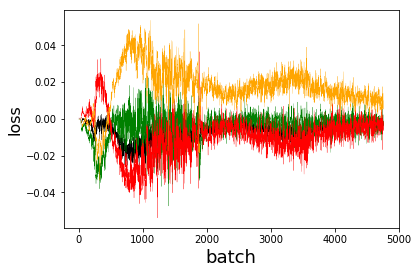

In [87]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

# plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()